<a href="https://colab.research.google.com/github/Makiato1999/ECG-Detector/blob/main/anomaly_detection_cnn_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch, os, platform, sys
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
!nvidia-smi

PyTorch: 2.9.0+cu126
CUDA available: False
/bin/bash: line 1: nvidia-smi: command not found


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shayanfazeli/heartbeat")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'heartbeat' dataset.
Path to dataset files: /kaggle/input/heartbeat


In [4]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
import matplotlib
import os


matplotlib.rcParams["figure.figsize"] = (6, 4)
plt.style.use("ggplot")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [5]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


In [6]:
normal_df = pd.read_csv("/kaggle/input/heartbeat/ptbdb_normal.csv").iloc[:, :-1]
anomaly_df = pd.read_csv("/kaggle/input/heartbeat/ptbdb_abnormal.csv").iloc[:, :-1]
normal_df.head()

,1.000000000000000000e+00,9.003241658210754395e-01,3.585899472236633301e-01,5.145867168903350830e-02,4.659643396735191345e-02,1.268233358860015869e-01,1.333063244819641113e-01,1.191247999668121338e-01,1.106158867478370667e-01,1.130470037460327148e-01,...,0.000000000000000000e+00.55,0.000000000000000000e+00.56,0.000000000000000000e+00.57,0.000000000000000000e+00.58,0.000000000000000000e+00.59,0.000000000000000000e+00.60,0.000000000000000000e+00.61,0.000000000000000000e+00.62,0.000000000000000000e+00.63,0.000000000000000000e+00.64
0,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.948983,0.505265,0.004176,0.022513,0.059550,0.107298,0.110385,0.111293,0.116558,0.118192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Exploratory Data Analysis

In [7]:
print("Shape of Normal data", normal_df.shape)
print("Shape of Abnormal data", anomaly_df.shape)

Shape of Normal data (4045, 187)
Shape of Abnormal data (10505, 187)


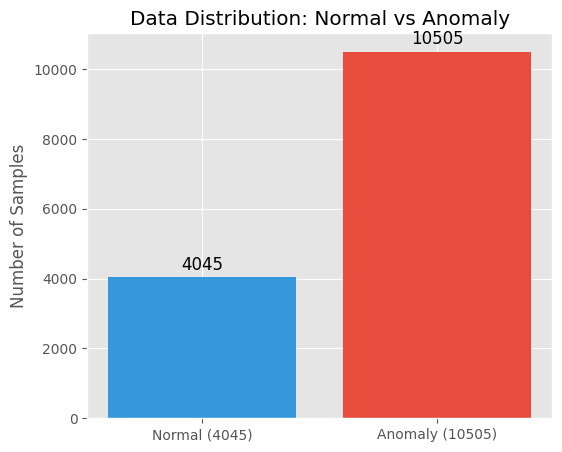

In [14]:
'''
目的：在报告中坦白承认数据是不平衡的，并解释为什么这对 Autoencoder 没问题。
“虽然正常样本较少（约 4000），但足以覆盖标准心跳模式。大量的异常样本（约 10000）将作为极佳的测试集，验证模型的泛化能力。”
'''
# 准备数据
counts = [len(normal_df), len(anomaly_df)]
labels = [f'Normal ({len(normal_df)})', f'Anomaly ({len(anomaly_df)})']
colors = ['#3498db', '#e74c3c'] # 蓝 vs 红

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, counts, color=colors)

# 在柱状图上标数值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 100, yval, ha='center', va='bottom', fontsize=12)

plt.title("Data Distribution: Normal vs Anomaly")
plt.ylabel("Number of Samples")
plt.show()

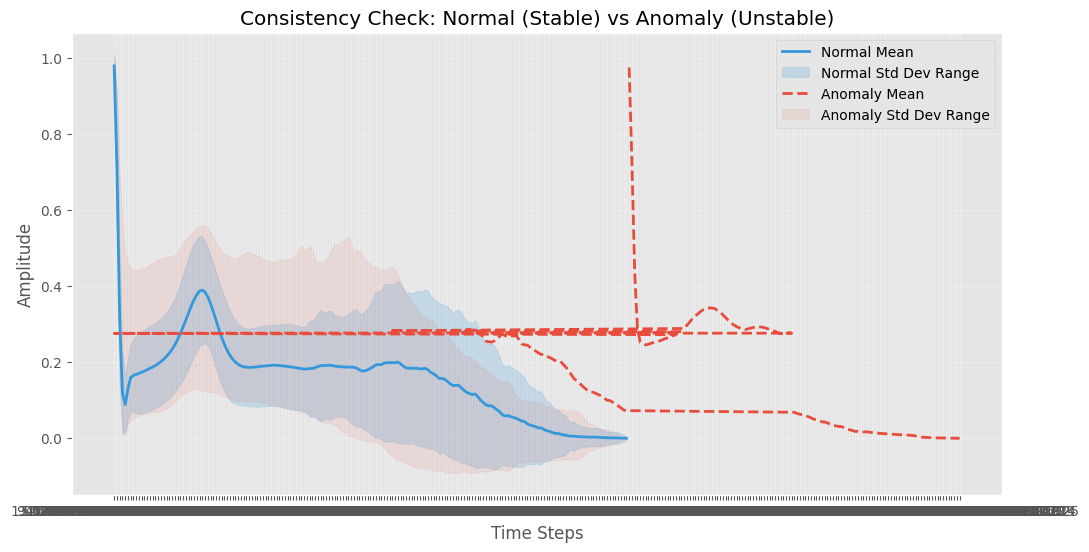

In [15]:
# 计算均值和标准差
normal_mean = normal_df.mean(axis=0)
normal_std = normal_df.std(axis=0)

# 加上异常数据的均值做对比
anomaly_mean = anomaly_df.mean(axis=0)
anomaly_std = anomaly_df.std(axis=0)

plt.figure(figsize=(12, 6))

# 1. 画正常的波动范围 (蓝色阴影)
plt.plot(normal_mean, color='#3498db', label='Normal Mean', linewidth=2)
plt.fill_between(range(187),
                 normal_mean - normal_std,
                 normal_mean + normal_std,
                 color='#3498db', alpha=0.2, label='Normal Std Dev Range')

# 2. 画异常的波动范围 (红色阴影)
plt.plot(anomaly_mean, color='#e74c3c', label='Anomaly Mean', linewidth=2, linestyle='--')
# 注意：异常数据的 Std 通常很大，画出来会包围住整个画面，这里我们只画线对比，或者画淡一点
plt.fill_between(range(187),
                 anomaly_mean - anomaly_std,
                 anomaly_mean + anomaly_std,
                 color='#e74c3c', alpha=0.1, label='Anomaly Std Dev Range')

plt.title("Consistency Check: Normal (Stable) vs Anomaly (Unstable)")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Normal Data Range: [0.00, 1.00]
Anomaly Data Range: [0.00, 1.00]


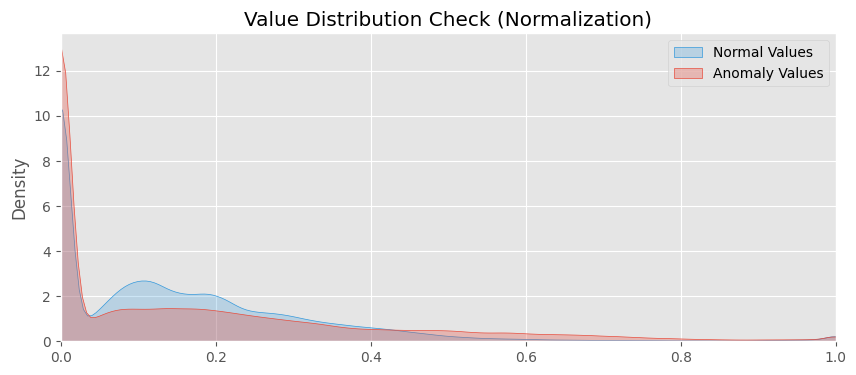

In [16]:
'''
数据已归一化至 [0, 1] 区间，且分布集中。这决定了我们的 Autoencoder 将使用 Sigmoid 激活函数作为输出层
'''
# 快速检查
print(f"Normal Data Range: [{normal_df.min().min():.2f}, {normal_df.max().max():.2f}]")
print(f"Anomaly Data Range: [{anomaly_df.min().min():.2f}, {anomaly_df.max().max():.2f}]")

# 画个简单的分布直方图
plt.figure(figsize=(10, 4))
sns.kdeplot(normal_df.values.flatten(), color='#3498db', fill=True, label='Normal Values')
sns.kdeplot(anomaly_df.values.flatten(), color='#e74c3c', fill=True, label='Anomaly Values', alpha=0.3)
plt.title("Value Distribution Check (Normalization)")
plt.xlim(0, 1)
plt.legend()
plt.show()

In [8]:
def plot_sample(normal, anomaly):
    index = np.random.randint(0, len(normal_df), 2)

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
    ax[0].plot(normal.iloc[index[0], :].values, label=f"Case {index[0]}")
    ax[0].plot(normal.iloc[index[1], :].values, label=f"Case {index[1]}")
    ax[0].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[0].set_title("Normal")

    ax[1].plot(anomaly.iloc[index[0], :].values, label=f"Case {index[0]}")
    ax[1].plot(anomaly.iloc[index[1], :].values, label=f"Case {index[1]}")
    ax[1].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[1].set_title("Anomaly")

    plt.tight_layout()
    plt.show()

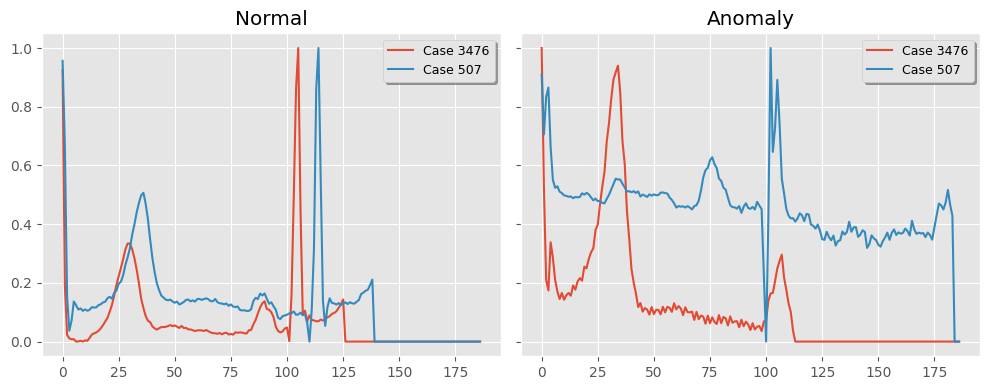

In [9]:
plot_sample(normal_df, anomaly_df)

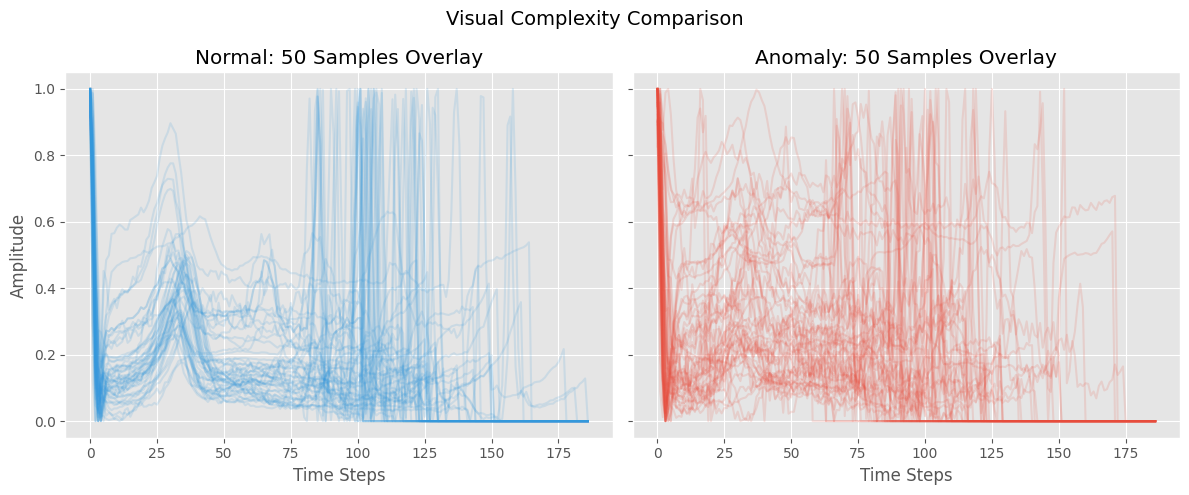

In [17]:
def plot_overlay_separate(normal, anomaly, n_samples=50):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

    # --- 左图：正常样本叠加 ---
    # 随机取 n_samples 个索引
    normal_indices = np.random.randint(0, len(normal), n_samples)
    for i in normal_indices:
        # alpha=0.1 让线条透明，叠加起来会有“聚光”的效果
        ax[0].plot(normal.iloc[i, :].values, color='#3498db', alpha=0.15)

    ax[0].set_title(f"Normal: {n_samples} Samples Overlay")
    ax[0].set_xlabel("Time Steps")
    ax[0].set_ylabel("Amplitude")

    # --- 右图：异常样本叠加 ---
    anomaly_indices = np.random.randint(0, len(anomaly), n_samples)
    for i in anomaly_indices:
        ax[1].plot(anomaly.iloc[i, :].values, color='#e74c3c', alpha=0.15)

    ax[1].set_title(f"Anomaly: {n_samples} Samples Overlay")
    ax[1].set_xlabel("Time Steps")

    plt.suptitle("Visual Complexity Comparison", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_overlay_separate(normal_df, anomaly_df)